In [1]:
#Importing Libraries
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

# Loading the Data sets

In [2]:
#Loading Datasets
rating = pd.read_csv('ratings.csv')

Checking the information of the data sets 

In [3]:
# Info of the dataframe
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [4]:
# drop() is a method used to remove the desired columns/rows from a dataframe
rating = rating.drop(['timestamp'], axis = 1)

now lets examine the top 10 records

In [5]:
rating.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


Exploring the datasets

In [6]:
# Finding number of unique users by using nunique method
rating['userId'].nunique()

610

There are 610 unique users in the "rating" dataset.

In [7]:
# Finding the number of unique movies
rating['movieId'].nunique()

9724

In [8]:
# Finding the frequency of movies rated by each user
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      1             1
       3             1
       6             1
       47            1
       50            1
...                ...
610    166534        1
       168248        1
       168250        1
       168252        1
       170875        1

[100836 rows x 1 columns]

In [9]:
# Finding the sum of ratings count by user-movie pair
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100836

The sum is equal to the total number of observations, which implies that there is only one interaction between a pair of a movie and a user.

In [10]:
# Counting the number of people who have watched a certain movie
rating['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

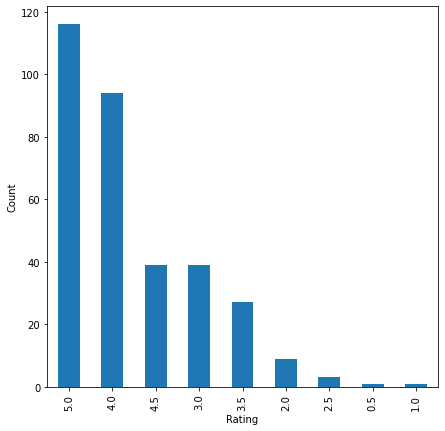

In [11]:
# Plotting distributions of ratings for 329 interactions with movieid 356

# Let us fix the size of the figure
plt.figure(figsize = (7, 7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind = 'bar')

# This gives a label to the variable on the x-axis
plt.xlabel('Rating')

# This gives a label to the variable on the y-axis
plt.ylabel('Count')

# This displays the plot
plt.show()

In [12]:
# Counting the number of movies each user has watched
rating['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

In [13]:
#Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

# Rank Based Recommendation System

Recommendations are given via rank-based recommendation systems based on the most well-liked products. When we experience a cold start issue, this type of recommendation system is helpful. The term "cold start" describes the problem that occurs when a new user joins the system and the machine is unable to suggest movies to him since the user has no prior interactions with the system that are stored in the dataset. In those circumstances, we can suggest movies to the new user using a rank-based recommendation algorithm.

The rank-based recommendation method is created by averaging all of the ratings given for each movie, after which the movies are ranked according to this average rating.

In [14]:
# Calculate average ratings for each movie
average_rating = rating.groupby('movieId').mean()['rating']

# Calculate the count of ratings for each movie
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [15]:
# First 5 records of the final_rating dataset
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49


To determine the top n movies for a suggestion based on average movie ratings, let's now develop a function. We can also include a requirement for a minimum quantity of interactions before a movie is given recommendation credit.

In [16]:
# It gives top n movies among those being watched for more than min_interactions
def top_n_movies(data, n, min_interaction = 100):
    
    # Finding movies with interactions greater than the minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    # Sorting values with respect to the average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    
    return recommendations.index[:n]

We can use this function with different n's and minimum interactions to get movies to be recommended.

Recommending top 5 movies with 50 minimum interactions based on popularity

In [17]:
list(top_n_movies(final_rating, 5, 50))

[318, 858, 2959, 1276, 750]

Recommending top 5 movies with 100 minimum interactions based on popularity

In [18]:
list(top_n_movies(final_rating, 5,100))

[318, 858, 2959, 1221, 48516]

# Collaborative Filtering Based Recommendation System

Building a baseline user-user similarity based recommendation system

we are creating a similarity-based recommendation system using cosine similarity and KNN to locate comparable people who are the given user's closest neighbors.
Surprise, we're going to use a new library to build the remaining models. Let's import the essential classes and functions from this library first.
To install the surprise library, kindly use the code below. When you initially execute the code, you just need to perform it once.

In [19]:
# Installing the surprise library
!pip install surprise

In [20]:
# To compute the accuracy of models
from surprise import accuracy

# Class to parse a file containing ratings, data should be in structure - user; item; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

Relevant item: An item (product in this case) that is actually rated higher than the threshold rating (here 3.5) is relevant, and an item that is actually rated lower than the threshold rating is a non-relevant item.

Recommended item: An item whose predicted rating is higher than the threshold (here 3.5) is a recommended item, and an item whose predicted rating is lower the threshold rating is a non-recommended item, i.e., it will not be recommended to the user.

False Negative (FN): It is the frequency of relevant items that are not recommended to the user. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the loss of opportunity for the service provider, which they would like to minimize.

False Positive (FP): It is the frequency of recommended items that are actually not relevant. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in loss of resources for the service provider, which they would also like to minimize.

Recall: It is the fraction of actually relevant items that are recommended to the user, i.e., if out of 10 relevant products, 6 are recommended to the user, then recall is 0.60. Higher the value of recall, better is the model. It is one of the metrics to do the performance assessment of classification models.

Precision: It is the fraction of recommended items that are relevant actually, i.e., if out of 10 recommended items, 6 are found relevant by the user, then precision is 0.60. The higher the value of precision, better is the model. It is one of the metrics to do the performance assessment of classification models.

In [21]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

Below we are converting the rating dataset, which is a pandas dataframe, into a different format called surprise.dataset.DatasetAutoFolds. This is required by the surprise library. To do this, we will be using the classes Reader and Dataset.

In [22]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are ready to build the first baseline similarity-based recommendation system using the cosine similarity.
KNNBasic is an algorithm that is also associated with the surprise package. It is used to find the desired similar items among a given set of items.

In [23]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(sim_user_user)

RMSE: 0.9823
Precision:  0.757
Recall:  0.542
F_1 score:  0.632


Now, let's predict the rating for the user with userId = 4 and the movie with movieId = 10 as shown below. Here, the user has already interacted or watched the movie with movieId 10.

In [24]:
# Predicting rating for a sample user with an interacted movie
sim_user_user.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.41   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.4133289774831344, details={'actual_k': 40, 'was_impossible': False})

The prediction for the user with userId = 4 and the movie with movieId = 10 is 3.41.

The above output demonstrates that the actual rating for this user-item pair is not significantly different from the projected rating by this user-user similarity-based baseline model.
"actual k" is also included in the output. When training the model, the value of K in the KNN is employed. 40 is the default value.

Below is the list of users who have seen the movie with movieId 3.

In [25]:
rating[rating.movieId == 3].userId.unique()

array([  1,   6,  19,  32,  42,  43,  44,  51,  58,  64,  68,  91, 100,
       102, 116, 117, 150, 151, 169, 179, 217, 226, 240, 269, 270, 288,
       289, 294, 302, 307, 308, 321, 330, 337, 368, 410, 414, 448, 456,
       470, 477, 480, 492, 501, 544, 552, 555, 588, 590, 594, 599, 608])

As the above list does not contain user id 4, we can say that user with user id 4 has not seen the movie with movieId 3.

In the below, we are predicting the rating for the same userId = 4 but for a movie with which this user has not interacted yet, i.e., movieId = 3.

In [26]:
# Predicting rating for a sample user with a non interacted movie
sim_user_user.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.260929007645626, details={'actual_k': 40, 'was_impossible': False})

The predicted rating for user with userId 4 and movie with movieId 3 is 3.26, even though this user has not interacted with this movie before.

In [27]:
# Predicting rating for a sample user with a non interacted movie
sim_user_user.predict(100, 300, verbose = True)

user: 100        item: 300        r_ui = None   est = 3.63   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=100, iid=300, r_ui=None, est=3.625291508753157, details={'actual_k': 40, 'was_impossible': False})

The predicted rating for user with userId = 100 and movie with movieId = 300 is 3.63.

Above, we have predicted the rating for this user-item pair based on this user-user similarity-based baseline model.

# Improving similarity-based recommendation system by tuning its hyperparameters

Hyperparameters for the KNNBasic algorithms will be tuned below. Let's attempt to explore a few of this algorithm's hyperparameters:

The (maximum) number of neighbors to consider for aggregation is indicated by the integer k. K has a default value of 40. The minimum number of neighbors to consider for aggregation is indicated by the integer _k. In the absence of sufficient neighbors, the prediction is set to the mean score across all countries. The initial setting is 1.
the dict sim options a list of alternatives for the similarity measure in a dictionary. In addition, four similarity measurements are readily available:

cosine
msd (default)
Pearson
Pearson baseline

Note: GridSearchCV does not accept the metrics recall@k, precision@k, or F1 Score@k. As a result, we'll tune the model using RMSE.

In [28]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [30, 40, 50], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-Fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on data
gs.fit(data)

# Printing the best RMSE score
print(gs.best_score['rmse'])

# Printing the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9481559577126856
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


After performing hyperparameter tuning using GridSearchCV, the best RMSE score achieved is 0.9477047857305485, and the hyperparameters that gave this score are k=30, min_k=3, and sim_options={'name': 'msd', 'user_based': True}.

Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above.

Now, let's build the final model by using the optimal values of the hyperparameters, which we received by using the grid search cross-validation.

In [29]:
# Using the optimal similarity measure for user-user collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 3, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9467
Precision:  0.762
Recall:  0.554
F_1 score:  0.642


Based on the above, we have tuned the hyperparameters for a model, and the resulting tuned model was compared to a baseline model. The F1 score and RMSE were used as performance metrics to evaluate the models.

The statement indicates that after tuning the hyperparameters, the F1 score of the tuned model increased slightly compared to the baseline model. Additionally, the RMSE of the tuned model decreased compared to the model before hyperparameter tuning.

Based on this information, we can conclude that the model's performance has improved slightly after hyperparameter tuning. However, it is worth noting that the degree of improvement and the overall performance of the model may still depend on other factors, such as the quality and quantity of the data, the choice of algorithms and features, and the specific use case.

Let us now predict the rating for the user with userId = 4 and the movie with movieId = 10 with the optimized model as shown below.

In [30]:
sim_user_user_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.50   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.497691535784751, details={'actual_k': 30, 'was_impossible': False})

If we compare the predicted rating with the actual raring, we can say that the predicted rating by the tuned model is closer to the actual rating in comparison to the prediction by the baseline model.

Below, we are predicting the rating for the same userId = 4 but for a movie with which this user has not interacted before, i.e., movieId = 3, by using the optimized model as shown below.

In [31]:
sim_user_user_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.45   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.4530529132024763, details={'actual_k': 30, 'was_impossible': False})

# Identifying similar users to a given user (nearest neighbors)

We can also find out similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to userId = 4 based on the msd distance metric.

In [32]:
sim_user_user_optimized.get_neighbors(4, k = 5)

[89, 90, 91, 181, 230]

# Implementing the recommendation algorithm based on optimized KNNBasic model

In [33]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'userId', columns = 'movieId', values = 'rating')
    
    # Extracting those movie IDs which the user ID has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie IDs which user ID has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie IDs by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    # Returing top n highest predicted rating movies for this user
    return recommendations[:top_n]

Predicted top 5 movies for userId = 4 using the similarity-based recommendation system.

In [34]:
# Making top 5 recommendations for userId 4 using the similarity-based recommendation system
recommendations = get_recommendations(rating, 4, 5, sim_user_user_optimized)

In [35]:
# Building the dataframe for above recommendations with columns "movieId" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings'])

,movieId,predicted_ratings
0,3404,5.000000
1,7121,5.000000
2,6460,4.844207
3,115122,4.813285
4,1178,4.808807


Updating the ratings and placing the above films
When comparing the ratings of two films, keep in mind that ratings do not solely reflect how likely viewers are to engage with a given film. The quantity of users who have watched that movie becomes vital to take into account in addition to the rating. As a result, we determined the "corrected ratings" for each film. In general, a movie's "rating count" indicates how trustworthy the rating is. A movie with a rating of 4 and a rating count of 3 is seen as being less liked than a movie with a rating of 3 and a rating count of 50. According to empirical research, the likelihood of the film is directly correlated with the inverse of the square root of the movie

In [36]:
def ranking_movies(recommendations, final_rating):

  # Sort the movies based on ratings count
  ranked_movies = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

  # Merge with the recommended movies to get predicted ratings
  ranked_movies = ranked_movies.merge(pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings']), on = 'movieId', how = 'inner')

  # Rank the movies based on corrected ratings
  ranked_movies['corrected_ratings'] = ranked_movies['predicted_ratings'] - 1 / np.sqrt(ranked_movies['rating_count'])

  # Sort the movies based on corrected ratings
  ranked_movies = ranked_movies.sort_values('corrected_ratings', ascending = False)
  
  return ranked_movies

Note: To obtain more optimistic forecasts using the above-corrected rating method, we can add the amount 1/np.sqrt(n) rather than subtract it. But, we are deducting this amount in this case because certain movies have ratings of 5, and we are not allowed to give a movie a rating higher than 5.

In [37]:
# Applying the ranking movies function and sorting it based on corrected ratings
ranking_movies(recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
1,3404,6,5.000000,4.591752
0,1178,12,4.808807,4.520132
3,7121,4,5.000000,4.500000
2,6460,5,4.844207,4.396993
4,115122,3,4.813285,4.235934


# Item-Item Similarity-Based Collaborative Filtering Recommendation Systems

In [38]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# The KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9800
Precision:  0.609
Recall:  0.464
F_1 score:  0.527


Here, F_1 score of the baseline model is ~0.53. We will try to improve this later by tuning different hyperparameters of this algorithm using GridSearchCV.

Let's now predict the rating for the user with userId = 4 and the movie with movieId = 10 as shown below. Here, the user has already interacted or watched the movie with movieId 10.

In [39]:
# Predicting rating for a sample user with an interacted movie
sim_item_item.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.63   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6257369831511945, details={'actual_k': 40, 'was_impossible': False})

we can also show below how we are predicting the rating for the same userId = 4 but for a movie with which this user has not interacted yet, i.e., movieId = 3.

In [40]:
# Predicting rating for a sample user with a non interacted movie
sim_item_item.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.67   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6748659322681623, details={'actual_k': 40, 'was_impossible': False})

# Improving similarity-based recommendation system by tuning its hyperparameters

we will be tuning hyperparameters of the KNNBasic algorithm.

In [41]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-Fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9170219143618793
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


We can see that the model's F 1 score is higher than the baseline model after hyperparameter adjustment. Moreover, the model's RMSE has decreased when compared to the model with default hyperparameters. So, we may conclude that following hyperparameter adjustment, the model's performance has increased.

Let's now predict the rating for the user with userId = 4 and the movie with movieId = 10 using the optimized model as shown below.

In [45]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9160
Precision:  0.678
Recall:  0.499
F_1 score:  0.575


In [46]:
sim_item_item_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.26   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.2569148418342952, details={'actual_k': 30, 'was_impossible': False})

In contrast to the optimized model, the baseline model's predicted rating was shown to be closer to the actual rating. This may be the case because, despite the fact that the aggregate score has gone up, the prognosis for this specific user is not that strong.

Below we are predicting the rating for the same userId = 4 but for a movie which this user has not interacted before, i.e., movieId = 3, by using the optimized model as shown below.

In [47]:
sim_item_item_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.57   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.574650247164053, details={'actual_k': 30, 'was_impossible': False})

# Identifying similar items to a given item (nearest neighbors)

In [48]:
sim_item_item_optimized.get_neighbors(4, k = 5)

[45, 73, 148, 155, 180]

Predicting top 5 movies for userId = 4 using the similarity-based recommendation system.

In [49]:
# Making top 5 recommendations for userId 4 using the similarity-based recommendation system
recommendations = get_recommendations(rating, 4, 5, sim_item_item_optimized)

In [50]:
# Building the dataframe for above recommendations with columns "movieId" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings'])

,movieId,predicted_ratings
0,5706,4.771028
1,176579,4.748016
2,25959,4.744049
3,2149,4.730439
4,56176,4.724374


In [51]:
# Applying the "ranking_movies" function and sorting it based on corrected ratings
ranking_movies(recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
0,2149,4,4.730439,4.230439
1,56176,3,4.724374,4.147023
2,5706,1,4.771028,3.771028
3,176579,1,4.748016,3.748016
4,25959,1,4.744049,3.744049


# Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a personalized recommendation system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use latent features to find recommendations for each user.

Building a baseline matrix factorization recommendation system

In [52]:
# Using SVD with matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the training dataset
svd.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd)

RMSE: 0.8797
Precision:  0.738
Recall:  0.507
F_1 score:  0.601


We can observe that the F_1 score for the matrix factorization model on the test set is lower in comparison to the F_1 score for the user-user-similarity recommendation system and optimized user-user similarity-based recommendation system.

Let's now predict the rating for the user with userId = 4 and the movie with movieId = 10 as shown below. Here, the user has already rated the movie.

In [53]:
# Making prediction for userId 4 and movieId 10
svd.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.33   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.333359479354037, details={'was_impossible': False})

The actual rating for this user-item pair is 4 and the predicted rating is far from the same. It seems that the model has under-estimated the rating. We will try to fix this by tuning the hyperparameters of the model using GridSearchCV.

Below, we are predicting rating for the same userId = 4 but for a movie which this user has not interacted before, i.e., movieId = 3, as shown below.

In [54]:
# Making prediction for userid 4 and movieId 3
svd.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 2.94   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=2.9386110726567756, details={'was_impossible': False})

# Improving matrix factorization based recommendation system by tuning its hyperparameters

Below we will be tuning only three hyperparameters:

n_epochs: The number of iterations of the SVD algorithm.
lr_all: The learning rate for all the parameters.
reg_all: The regularization term for all the parameters.

In [55]:
# Set the parameter space to do hyperparameter tuning
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-Fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8733230633379175
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will build the model using the optimal values of hyperparameters that we received from the grid search cross-validation.

In [56]:
# Building the optimized SVD model using optimal hyperparameters search
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.8752
Precision:  0.731
Recall:  0.511
F_1 score:  0.602


We can observe that after tuning hyperparameters, the model performance has not improved by much.

Let's now predict the rating for the user with userId = 4 and the movie with movieId = 10 with the optimized model as shown below.

In [57]:
# Using svd_algo_optimized model to recommend for userId 4 and movieId 10
svd_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.39   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.3892642624049993, details={'was_impossible': False})

In [58]:
# Using svd_algo_optimized model to recommend for userId 4 and movieId 3 with unknown baseline rating
svd_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.20   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.20286300753659, details={'was_impossible': False})

Now, let's recommend the movies using the optimized svd model.

In [59]:
# Getting top 5 recommendations for userId 4 using "svd_algo_optimized" algorithm
svd_recommendations = get_recommendations(rating, 4, 5, svd_optimized)

In [60]:
# Ranking movies based on above recommendations
ranking_movies(svd_recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
0,1178,12,4.446400,4.157725
1,177593,8,4.380428,4.026875
2,106642,7,4.379596,4.001631
3,3266,6,4.332485,3.924236
4,7121,4,4.342665,3.842665


Summary
In this case study, we built recommendation systems using four different algorithms. They are as follows:

Rank-based using averages
User-User similarity-based collaborative filtering
Item-Item similarity-based collaborative filtering
Model-based collaborative filtering (matrix factorization)
The surprise library was used to demonstrate"user-user similarity-based collaborative filtering," "item-item similarity-based collaborative filtering," and "model-based collaborative filtering (matrix factorization)" algorithms. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and related predictions are created using the optimal hyperparameters.
For performance evaluation of these models precision@k and recall@k are used. Using these two metrics, the F_1 score is calculated for each working model.
Overall, the user-user similarity-based recommendation system has given the best performance in terms of the F1-Score.
We can try to further improve the performance of these models using hyperparameter tuning.
We can also combine different recommendation techniques to build hybrid recommendation systems.

Next we will perform Neural Collaborative Filtering (NCF) and Variational Autoencoders (VAEs)

# Neural Collaborative Filtering